In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## 컬럼 분류

In [4]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


## CovariateShift

In [5]:
train['race']=pd.factorize(train['race'])[0]
test['race']=pd.factorize(test['race'])[0]

train = pd.get_dummies(train, columns=['race'])
test = pd.get_dummies(test, columns=['race'])

train.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)
test.drop(['race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6'], axis=1, inplace=True)


train.drop('religion', axis=1, inplace=True)
test.drop('religion', axis=1, inplace=True)

### Q_A

In [6]:
Q_A = meta[meta.gbn=='Q_A'].index

train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


In [7]:
minus_cols = ["QeA", "QfA", "QkA", "QqA", "QrA","QaA", "QdA", "QgA", "QiA", "QnA"]
for f in minus_cols: 
    train[f] = 6 - train[f]
    test[f] = 6 - test[f]

In [8]:
train['Mach_score'] = train[Q_A].mean(axis = 1)
test['Mach_score'] = test[Q_A].mean(axis = 1)

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,race_0,Mach_score
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,5.0,1024,4.0,1577,...,0,1,1,0,1,0,1,1,1,2.95
1,1.0,647,5.0,1313,3.0,3387,1.0,2969,5.0,4320,...,0,1,1,0,1,0,1,1,0,2.60
2,2.0,1623,1.0,1480,1.0,1021,2.0,3374,1.0,1333,...,0,1,1,1,1,0,1,1,1,1.90
3,3.0,504,3.0,2311,4.0,992,3.0,3245,5.0,357,...,0,0,1,0,1,0,1,1,0,3.35
4,5.0,927,1.0,707,5.0,556,4.0,1062,5.0,1014,...,1,1,1,0,1,1,1,1,1,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,4.0,1050,5.0,619,4.0,328,5.0,285,5.0,602,...,0,1,1,1,1,0,1,1,1,4.15
45528,4.0,581,3.0,1353,4.0,1164,5.0,798,3.0,1680,...,0,1,1,1,1,0,1,1,1,3.80
45529,2.0,593,1.0,857,1.0,1047,2.0,1515,1.0,1690,...,0,1,1,0,1,0,1,1,1,1.50


### Q_A 1/5 count

In [ ]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q_A15'] = 0
train['Q_A3'] = 0

test['Q_A15'] = 0
test['Q_A3'] = 0

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1
        elif v == 3:
            train.loc[i, 'Q_A3'] = train.loc[i, 'Q_A3']+1
        elif v == 5:
            train.loc[i, 'Q_A15'] = train.loc[i, 'Q_A15']+1            

In [ ]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1
        elif v == 3:
            test.loc[i, 'Q_A3'] = test.loc[i, 'Q_A3']+1            
        elif v == 5:
            test.loc[i, 'Q_A15'] = test.loc[i, 'Q_A15']+1                        

### Q_E

In [ ]:
Q_E = meta[meta.gbn == 'Q_E'].index

train[Q_E].describe()
train[Q_E].head()

In [ ]:
train[Q_E]

In [ ]:
for f in Q_E:
    train[f] = np.log1p(train[f])
    test[f] = np.log1p(test[f])

In [ ]:
train[Q_E]

### tp

In [ ]:
# 0~7 
tp = meta[meta.gbn=='tp'].index

train[tp].describe()
train[tp].head(3)

In [ ]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 7:
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        elif v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

In [ ]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 7:
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        elif v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

#### 극단값 중간값

In [ ]:
train['Q_A15tp17'] = train['Q_A15'] + train['tp17']
train['Q_A3tp4'] = train['Q_A3'] + train['tp4']

In [ ]:
test['Q_A15tp17'] = test['Q_A15'] + test['tp17']
test['Q_A3tp4'] = test['Q_A3'] + test['tp4']

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

## Target Encoding

### age_group

In [9]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [10]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [11]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [12]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [13]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [14]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

### outlier

In [15]:
train = train[train.familysize < 25]

In [ ]:
train.shape, train.columns

In [ ]:
test.shape, test.columns

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [16]:
#col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat = ['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
# 'race_0',
 #'religion',
 'urban'
#,'Priority'
          ]

In [17]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'voted'
          , categorical_features=col_cat
          , numeric_features = ['race_0']#,,'tp17','tp4','Q_A15','Q_A3','Q_A15tp17','Q_A3tp4']#['Q_A1','Q_A3','Q_A5','tp17','tp4','Q_A15tp17','Q_A3tp4']
          #, ignore_features =['Priority']#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45524, 78)"
4,Missing Values,False
5,Numeric Features,23
6,Categorical Features,54
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 26.6 s


In [18]:
best_5 = compare_models(sort = 'AUC', n_select = 5
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6939,0.7638,0.6518,0.7550,0.6996,0.3910,0.3954,24.6651
1,CatBoost Classifier,0.6918,0.7623,0.6557,0.7494,0.6994,0.3861,0.3897,28.5026
2,Light Gradient Boosting Machine,0.6887,0.7597,0.6474,0.7492,0.6946,0.3806,0.3848,9.2173
3,Linear Discriminant Analysis,0.6862,0.7582,0.6541,0.7416,0.6951,0.3745,0.3777,1.0846
4,Extra Trees Classifier,0.6889,0.7561,0.6330,0.7582,0.6900,0.3829,0.3892,2.9016
5,Ada Boost Classifier,0.6852,0.7545,0.6510,0.7417,0.6934,0.3727,0.3760,9.7025
6,Extreme Gradient Boosting,0.6722,0.7397,0.6679,0.7141,0.6902,0.3430,0.3439,14.2281
7,Random Forest Classifier,0.6523,0.7102,0.6017,0.7170,0.6543,0.3099,0.3147,0.8367
8,Decision Tree Classifier,0.6106,0.6072,0.6437,0.6441,0.6439,0.2143,0.2143,3.0610
9,K Neighbors Classifier,0.5144,0.5123,0.5553,0.5560,0.5556,0.0204,0.0204,2.2944


In [19]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6963,0.7648,0.6607,0.7536,0.7041,0.3950,0.3986
1,0.7034,0.7689,0.6672,0.7611,0.7111,0.4091,0.4129
2,0.6933,0.7673,0.6453,0.7578,0.6971,0.3906,0.3958
3,0.6886,0.7637,0.6523,0.7462,0.6961,0.3798,0.3834
4,0.6895,0.7678,0.6441,0.7524,0.6941,0.3827,0.3875
Mean,0.6943,0.7665,0.6539,0.7542,0.7005,0.3915,0.3956
SD,0.0054,0.0019,0.0089,0.0051,0.0063,0.0104,0.0102


In [20]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6983,0.7637,0.6578,0.7585,0.7046,0.3995,0.4038


In [21]:
%%time
final_model = finalize_model(blended)

Wall time: 15min 46s


In [24]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [25]:
submission['voted'] = predictions['Score']

# 5. 제출

In [26]:
submission.to_csv('output/20201011-2.csv')

In [27]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6979,0.7720,0.6541,0.7600,0.7031,0.3991,0.4038
1,0.6889,0.7471,0.6566,0.7444,0.6977,0.3799,0.3831
2,0.6907,0.7602,0.6500,0.7509,0.6968,0.3845,0.3887
3,0.7082,0.7754,0.6680,0.7681,0.7146,0.4191,0.4233
4,0.6992,0.7729,0.6574,0.7602,0.7051,0.4015,0.4059
5,0.6889,0.7601,0.6443,0.7514,0.6937,0.3815,0.3861
6,0.6883,0.7643,0.6385,0.7541,0.6915,0.3810,0.3864
7,0.6865,0.7556,0.6571,0.7403,0.6962,0.3748,0.3777
8,0.7031,0.7759,0.6546,0.7680,0.7068,0.4100,0.4154
9,0.6870,0.7546,0.6374,0.7522,0.6901,0.3783,0.3836


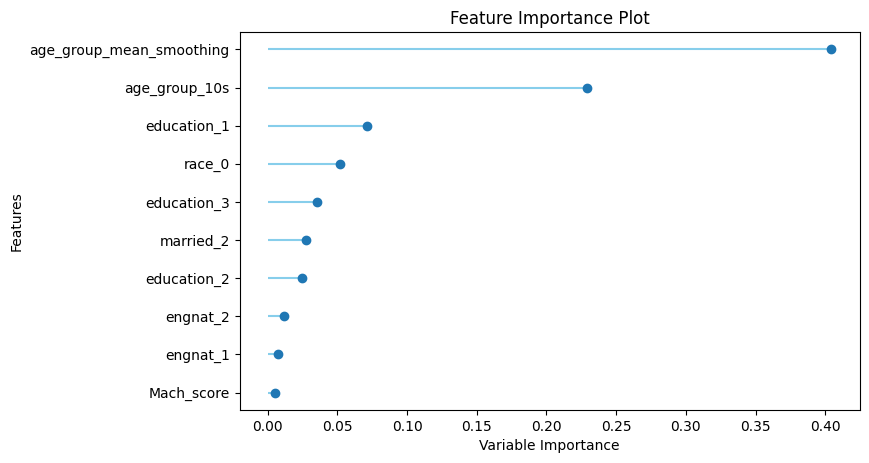

In [28]:
plot_model(estimator = gbc, plot = 'feature')

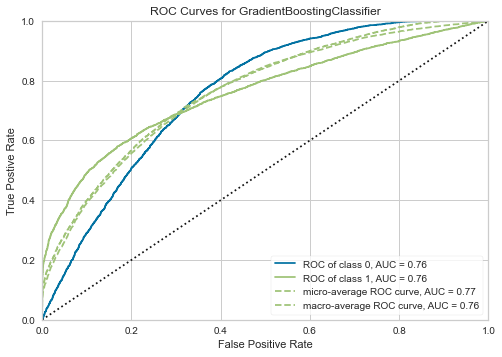

In [29]:
plot_model(estimator = gbc, plot = 'auc')

In [30]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6912,0.7662,0.6516,0.7507,0.6977,0.3853,0.3893
1,0.6827,0.7513,0.6369,0.7457,0.6870,0.3692,0.3739
2,0.6871,0.7582,0.6475,0.7467,0.6936,0.3773,0.3813
3,0.7015,0.7671,0.6672,0.7579,0.7097,0.4050,0.4085
4,0.6970,0.7699,0.6533,0.7590,0.7022,0.3973,0.4020
5,0.6853,0.7612,0.6508,0.7421,0.6934,0.3731,0.3765
6,0.6883,0.7494,0.6361,0.7556,0.6907,0.3813,0.3870
7,0.6816,0.7495,0.6489,0.7372,0.6902,0.3655,0.3686
8,0.6897,0.7699,0.6440,0.7526,0.6941,0.3831,0.3879
9,0.6825,0.7544,0.6374,0.7450,0.6870,0.3688,0.3734


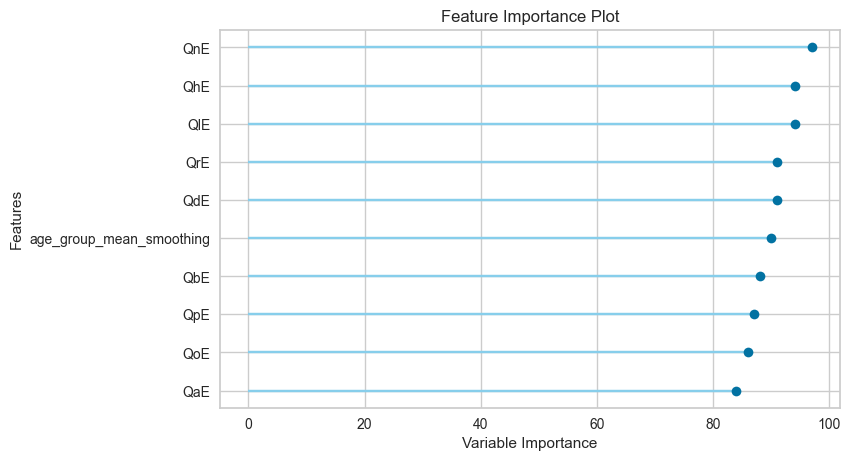

In [31]:
plot_model(estimator = lightgbm, plot = 'feature')